<a href="https://colab.research.google.com/github/Engineer-Ayesha-Shafique/Brain-Tumor-Segmentation-and-Detection-using-UNET-and-Watershed-in-Python/blob/main/Brain_Tumor_Segmentation_and_Detection_using_UNET_and_Watershed_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#UNET

https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Conv2DTranspose,
    Concatenate,
    Input
)

def convolution_block(input_value, no_of_filters):
    """
    A convolutional block consisting of two convolutional layers followed by batch normalization and ReLU activation.

    Args:
        input_value (Tensor): Input tensor.
        no_of_filters (int): Number of filters for convolutional layers.

    Returns:
        Tensor: Output tensor.
    """
    conv_value = Conv2D(no_of_filters,  # Number of filters
                        3,              # Kernel size
                        padding="same"  # Padding to ensure the output has the same spatial dimensions as the input
                        )(input_value)

    conv_value = BatchNormalization()(conv_value)

    conv_value = Activation("relu")(conv_value)

    conv_value = Conv2D(no_of_filters,  # Number of filters
                        3,              # Kernel size
                        padding="same"  # Padding to ensure the output has the same spatial dimensions as the input
                        )(conv_value)

    conv_value = BatchNormalization()(conv_value)

    conv_value = Activation("relu")(conv_value)

    return conv_value

def encoder(input_value, no_of_filters):
    """
    Encoder block that performs a convolutional block followed by max pooling.

    Args:
        input_value (Tensor): Input tensor.
        no_of_filters (int): Number of filters for convolutional layers.

    Returns:
        Tensor: Encoder output tensor.
        Tensor: Pooled output tensor.
    """
    encoder_value = convolution_block(input_value, no_of_filters)
    pool_value = MaxPooling2D((2, 2))(encoder_value)
    return encoder_value, pool_value

def decoder(input_value, skip_features, no_of_filters):
    """
    Decoder block that performs transpose convolution, concatenation with skip connections,
    and a convolutional block.

    Args:
        input_value (Tensor): Input tensor.
        skip_features (Tensor): Skip connection tensor from the encoder block.
        no_of_filters (int): Number of filters for convolutional layers.

    Returns:
        Tensor: Decoder output tensor.
    """
    decoder_value = Conv2DTranspose(no_of_filters, 2, strides=2, padding="same")(input_value)
    decoder_value = Concatenate()([decoder_value, skip_features])
    decoder_value = convolution_block(decoder_value, no_of_filters)
    return decoder_value

def Unet_model(input_shape):
    """
    UNet model implementation with an input shape.

    Args:
        input_shape (tuple): Shape of the input data.

    Returns:
        Model: UNet model.
    """
    # Input layer
    input_value = Input(input_shape)

    # Encoder
    encoder_1_value, pool_1_value = encoder(input_value, 64)          
    encoder_2_value, pool_2_value = encoder(pool_1_value, 128) 
    encoder_3_value, pool_3_value = encoder(pool_2_value, 256)  
    encoder_4_value, pool_4_value = encoder(pool_3_value, 512)  

    # Convolution block
    conv_value_1 = convolution_block(pool_4_value, 1024)

    # Decoder
    decoder_1_value = decoder(conv_value_1, encoder_4_value, 512)       
    decoder_2_value = decoder(decoder_1_value, encoder_3_value, 256)    
    decoder_3_value = decoder(decoder_2_value, encoder_2_value, 128)    
    decoder_4_value = decoder(decoder_3_value, encoder_1_value, 64)     
    
    #Output Layer
    output_value = Conv2D(1,                      # Number of filters
                          1,                      # Kernel size
                          padding="same",         # Padding to ensure the output has the same spatial dimensions as the input
                          activation="sigmoid"    # Activation function applied to the output
                          )(decoder_4_value)

    #Model compliation
    model_result = Model(input_value,          # Input layer
                  output_value,         # Output layer
                  name="UNET"           # Model name (optional)
    )

    return  model_result

if __name__ == "__main__":

    # Defines the shape of the input data: 256x256 pixels with 3 color channels (RGB)
    input_shape = (256, 256, 3)
        
    # Creates an instance of the UNet model with the specified input shape
    model_result = Unet_model(input_shape)

    # Prints a summary of the model's architecture, including the number of parameters and layer shapes
    model_result.summary()


Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

# Metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15

def dice_coefficient(true_mask, pred_mask):
    """
    Dice coefficient metric for evaluating the similarity between ground truth and predicted segmentation masks.

    Args:
        true_mask: Ground truth segmentation masks.
        pred_mask: Predicted segmentation masks.

    Returns:
        Dice coefficient score.
    """
    true_mask = tf.keras.layers.Flatten()(true_mask)  # Flatten the ground truth masks
    pred_mask = tf.keras.layers.Flatten()(pred_mask)  # Flatten the predicted masks

    intersection = tf.reduce_sum(true_mask * pred_mask)  # Calculate the intersection between the masks

    return (2. * intersection + smooth) / (tf.reduce_sum(true_mask) + tf.reduce_sum(pred_mask) + smooth)
    # Calculate the Dice coefficient score

def dice_coefficient_loss (true_mask, pred_mask):
    """
    The Dice loss function for training a model based on the Dice coefficient.

    Args:
        true_mask: Ground truth segmentation masks.
        pred_mask: Predicted segmentation masks.

    Returns:
        Dice loss value.
    """
    # Calculate the Dice loss by taking negative logarithm of the Dice coefficient 
    return -K.log(dice_coefficient(true_mask, pred_mask))


#Train


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

""" Global parameters """
Height = 256
Width = 256

"""
Create a directory if it does not exist in drive.

Args:
    path: Path of the directory to be created.
"""
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)

"""
Load the dataset from the given path and split it into training, validation, and test sets.

Args:
    path_dataset: Path of the dataset directory.
    splitting_ratio: Split ratio for training-validation-testing.

Returns:
    Tuple containing the training, validation, and testing sets.
"""
def load_dataset(path_dataset, splitting_ratio=0.2):
    images = sorted(glob(os.path.join(path_dataset, "images", "*.png")))
    masks = sorted(glob(os.path.join(path_dataset, "masks", "*.png")))
    print(len(images))
    print(len(masks))
    splitting_size = int(len(images) * splitting_ratio )
    training_img, validation_img = train_test_split(images, test_size=splitting_size, random_state=42)
    training_mask, validation_mask = train_test_split(masks, test_size=splitting_size, random_state=42)

    training_img, testing_img = train_test_split(training_img, test_size=splitting_size, random_state=42)
    training_mask, testing_mask = train_test_split(training_mask, test_size=splitting_size, random_state=42)

    return (training_img, training_mask), (validation_img, validation_mask), (testing_img, testing_mask)

"""
Read and preprocess an image from the given path.

Args:
    path_img: Path of the image file.

Returns:
    Preprocessed image.
"""
def read_image_file(path_img):
    path_img = path_img.decode()
    img_preprocess = cv2.imread(path_img, cv2.IMREAD_COLOR)
    img_preprocess = cv2.resize(img_preprocess, (Width, Height))
    img_preprocess = img_preprocess / 255.0
    img_preprocess = img_preprocess.astype(np.float32)
    return img_preprocess

"""
Read and preprocess a mask from the given path.

Args:
    path_mask: Path of the mask file.

Returns:
    Preprocessed mask.
"""
def read_mask_file(path_maks):
    path_mask = path_mask.decode()
    mask_preprocess = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)  
    mask_preprocess = cv2.resize(mask_preprocess, (Width, Height))   
    mask_preprocess = mask_preprocess / 255.0               
    mask_preprocess = mask_preprocess.astype(np.float32)    
    mask_preprocess = np.expand_dims(mask_preprocess, axis=-1)
    return mask_preprocess

"""
TensorFlow parse function to read and preprocess the images and masks.

Args:
    path_img: Path of the image file.
    path_mask: Path of the mask file.

Returns:
    Preprocessed image and mask.
"""
def tf_parse(path_img, path_mask):
    def _parse(path_img, path_mask):
        path_img = read_image_file(path_img)
        path_mask = read_mask_file(path_mask)
        return path_img, path_mask

    path_img, path_mask = tf.numpy_function(_parse, [path_img, path_mask], [tf.float32, tf.float32])
    path_img.set_shape([Height, Width, 3])
    path_mask.set_shape([Height, Width, 1])
    return path_img, path_mask

"""
Create a TensorFlow dataset from input and target data.

Args:
    Input_data: Input data.
    Output_data: Target data.
    Batch_size: Batch size.

Returns:
    TensorFlow dataset.
"""
def tf_dataset(Input_data, Output_data, batch_size=2):
    dataset_tensor = tf.data.Dataset.from_tensor_slices((Input_data, Output_data))
    dataset_tensor = dataset_tensor.map(tf_parse)
    dataset_tensor = dataset_tensor.batch(batch_size)
    dataset_tensor = dataset_tensor.prefetch(10)
    return dataset_tensor

if __name__ == "__main__":
    """ Seeding the tensor"""

    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files in drive """
    create_folder("/content/drive/MyDrive/DSP Project/files")

    """ Hyperparameters """
    size_of_batch = 16
    lr = 1e-4
    epochs_num = 100
    path_model = os.path.join("/content/drive/MyDrive/DSP Project/files", "model.h5")
    path_csv = os.path.join("/content/drive/MyDrive/DSP Project/files", "log.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data"
    (training_img, training_mask), (validation_img, validation_mask), (testing_img, testing_mask) = load_dataset(dataset_path)

    print(f"training: {len(training_img)} - {len(training_mask)}")
    print(f"validation: {len(validation_img)} - {len(validation_mask)}")
    print(f"testing : {len(testing_img)} - {len(testing_mask)}")

    training_dataset = tf_dataset(training_img, training_mask, batch_size=size_of_batch)
    validation_dataset = tf_dataset(validation_img, validation_mask, batch_size=size_of_batch)



3064
3064
training: 1840 - 1840
validation: 612 - 612
testing : 612 - 612


In [ ]:
""" Model """
# Create the U-Net model with the specified input shape
model_result = Unet_model((Height, Width, 3))

# Compile the model with the dice_coefficient_loss as the loss function, Adam optimizer with specified learning rate, and dice_coefficient as the evaluation metric
model_result.compile(loss=dice_coefficient_loss, optimizer=Adam(lr), metrics=[dice_coefficient])

# Define the callbacks for model training
callbacks = [
    # Save the best model during training based on validation loss
    ModelCheckpoint(path_model, verbose=1, save_best_only=True),
    # Reduce the learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # Log the training and validation metrics to a CSV file
    CSVLogger(path_csv),
    # Early stopping to stop training if validation loss doesn't improve for a certain number of epochs
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

# Train the model on the training dataset, validate on the validation dataset, and utilize the defined callbacks
model_result.fit(
    training_dataset,
    epochs = epochs_num,
    validation_data = validation_dataset,
    callbacks = callbacks
)


Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.8658 - dice_coef: 0.1342
Epoch 1: val_loss improved from inf to 0.96544, saving model to /content/drive/MyDrive/DSP Project/files/model.h5
115/115 [==============================] - 133s 946ms/step - loss: 0.8658 - dice_coef: 0.1342 - val_loss: 0.9654 - val_dice_coef: 0.0345 - lr: 1.0000e-04
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.7360 - dice_coef: 0.2640
Epoch 2: val_loss did not improve from 0.96544
115/115 [==============================] - 104s 903ms/step - loss: 0.7360 - dice_coef: 0.2640 - val_loss: 0.9823 - val_dice_coef: 0.0177 - lr: 1.0000e-04
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.6514 - dice_coef: 0.3486
Epoch 3: val_loss improved from 0.96544 to 0.94007, saving model to /content/drive/MyDrive/DSP Project/files/model.h5
115/115 [==============================] - 118s 1s/step - loss: 0.6514 - dice_coef: 0.3486 - val_loss: 0.9401 - val_dic

KeyboardInterrupt: ignored

#Test


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

""" Global parameters """
Height = 256
Width = 256

""" Creating a directory in drive """
def create_folder(path):
    """
    Create a directory if it does not exist.

    Args:
        path: Path to the directory.
    """
    if not os.path.exists(path):
        os.makedirs(path)

def Result_saving(inp_image, m_true, p_mask, path_saved_image):
    """
    Save the image, ground truth mask, and predicted mask side by side.

    Args:
        inp_image: Input image.
        m_true: Ground truth mask.
        p_mask: Predicted mask.
        path_saved_image: Path to save the image.
    """
    m_true  =  np.expand_dims ( m_true, axis=-1)
    m_true  =  np.concatenate ( [ m_true, m_true, m_true], axis=-1 ) 

    p_mask = np.expand_dims ( p_mask, axis=-1)
    p_mask = np.concatenate ( [ p_mask, p_mask, p_mask], axis=-1)
    p_mask = p_mask * 255

    line = np.ones((Height, 10, 3)) * 255

    concat_images = np.concatenate([inp_image, line, m_true, line, p_mask], axis=1)
    cv2.imwrite(path_saved_image, concat_images )

if __name__ == "__main__":
    """ Seeding the tensor """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_folder("/content/drive/MyDrive/DSP Project/results")

    """ Loading the model from drive"""
    with CustomObjectScope({"dice_coef": dice_coefficient, "dice_loss": dice_coefficient_loss}):
        model_loaded = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/DSP Project/files", "model.h5"))

    """ loading the dataset from drive"""
    path_dataset ="/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data"
    (training_img, training_mask), (validation_img, validation_mask), (testing_img, testing_mask) = load_dataset(path_dataset)

    """ Model Prediction and Evaluation along with score saving to drive """
    EVL_SCORE_list = []
    for im, msk in tqdm(zip(testing_img, testing_mask), total=len(testing_mask)):
        """ Extracting the name of image """
        n_img = im.split("/")[-1]

        """ Reading the image """
        inp_image = cv2.imread(im, cv2.IMREAD_COLOR) ## [Height, Width, 3]
        inp_image = cv2.resize(inp_image, (Width, Height))       ## [Height, Width, 3]
        im = inp_image/255.0                         ## [Height, Width, 3]
        im = np.expand_dims(im, axis=0)           ## [1, Height, Width, 3]

        """ Reading the mask """
        m_true = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
        m_true = cv2.resize(m_true, (Width, Height))

        """ Predicting mask """
        p_mask = model_loaded.predict(im, verbose=0)[0]
        p_mask = np.squeeze(p_mask, axis=-1)
        p_mask = p_mask >= 0.5
        p_mask = p_mask.astype(np.int32)

        """ Save the predicting mask result """
        path_saved_image = os.path.join("/content/drive/MyDrive/DSP Project/results", n_img)
        Result_saving(inp_image, m_true, p_mask, path_saved_image)

        """ Flatten the array """
        m_true = m_true/255.0
        m_true = (m_true > 0.5).astype(np.int32).flatten()
        p_mask = p_mask.flatten()

        """ finding the evalution value """
        f1_scoree = f1_score(m_true, p_mask, labels=[0, 1], average="binary")
        jaccard_scoree = jaccard_score(m_true, p_mask, labels=[0, 1], average="binary")
        recall_scoree = recall_score(m_true, p_mask, labels=[0, 1], average="binary", zero_division=0)
        precision_scoree = precision_score(m_true, p_mask, labels=[0, 1], average="binary", zero_division=0)
        EVL_SCORE_list.append([n_img, f1_scoree, jaccard_scoree, recall_scoree, precision_scoree])

    """ EEvluation Matrix """
    evl_score_val = [s[1:]for s in EVL_SCORE_list]
    evl_score_val = np.mean(evl_score_val, axis=0)
    print(f"F1: {evl_score_val[0]:0.5f}")
    print(f"Jaccard: {evl_score_val[1]:0.5f}")
    print(f"Recall: {evl_score_val[2]:0.5f}")
    print(f"Precision: {evl_score_val[3]:0.5f}")

    df = pd.DataFrame(EVL_SCORE_list, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/DSP Project/files/score.csv")


3064
3064


100%|██████████| 612/612 [07:07<00:00,  1.43it/s]


F1: 0.75996
Jaccard: 0.67408
Recall: 0.75194
Precision: 0.82348


#Plot and Checks

In [ ]:
import pandas as pd
metrics = pd.read_csv("/content/drive/MyDrive/DSP Project/files/log.csv")
metrics.head(10)

,epoch,dice_coef,loss,lr,val_dice_coef,val_loss
0,0,0.134170,0.865830,0.0001,0.034529,0.965438
1,1,0.264001,0.736000,0.0001,0.017694,0.982325
2,2,0.348605,0.651395,0.0001,0.060875,0.940072
3,3,0.432483,0.567517,0.0001,0.214499,0.783377
4,4,0.498895,0.501105,0.0001,0.392823,0.608265
5,5,0.575070,0.424930,0.0001,0.452358,0.542742
6,6,0.624534,0.375466,0.0001,0.500481,0.500091
7,7,0.673571,0.326429,0.0001,0.638665,0.358800
8,8,0.700212,0.299788,0.0001,0.553839,0.441639
9,9,0.727993,0.272007,0.0001,0.621600,0.370159


<Axes: >

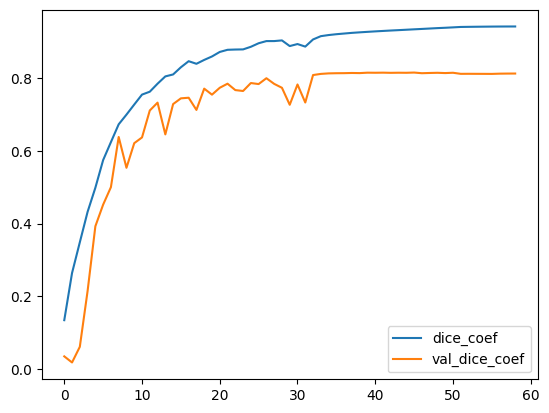

In [ ]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

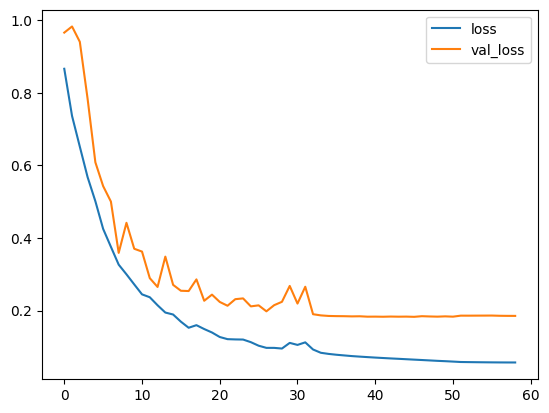

In [ ]:
metrics[['loss','val_loss']].plot()

In [ ]:
scores = pd.read_csv("/content/drive/MyDrive/DSP Project/files/score.csv")
scores.head(10)

,Unnamed: 0,Image,F1,Jaccard,Recall,Precision
0,0,833.png,0.922222,0.855670,0.876761,0.972656
1,1,2069.png,0.872762,0.774247,0.985106,0.783418
2,2,3038.png,0.820119,0.695087,0.749221,0.905838
3,3,1169.png,0.952381,0.909091,0.915948,0.991832
4,4,501.png,0.963944,0.930398,0.964654,0.963235
5,5,31.png,0.962454,0.927626,0.930912,0.996209
6,6,2242.png,0.912567,0.839194,0.943133,0.883921
7,7,1014.png,0.926752,0.863501,0.863501,1.000000
8,8,1322.png,0.855524,0.747525,0.798942,0.920732
9,9,1779.png,0.913473,0.840728,0.969816,0.863318


#Watershed implementation for automataing segmentation

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

def ShowImage(list_img, list_t, list_cm):
    """
    Display multiple images with corresponding titles and colormaps.

    Args:
        list_img (list): List of images to be displayed.
        list_t (list): List of titles for each image.
        list_cm (list): List of colormaps for each image.
    """
    no_of_img = len(list_img)
    figure, axis_label = plt.subplots(1, no_of_img, figsize = (10*no_of_img, 10))
    for x  in range(no_of_img):
        axis_label[x].imshow(list_img[x], cmap=list_cm[x])
        axis_label[x].axis('off')
        axis_label[x].set_title(list_t[x])
    plt.show()

def watershed(path_img):
    """
    Apply watershed segmentation to an image.

    Args:
        path_img (str): Path to the input image.
    """
    # Read the image
    color_image = cv2.imread(path_img)
    grey_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to obtain a binary image
    computed_threshold, threshold = cv2.threshold(grey_img, 0, 255, cv2.THRESH_OTSU)
    computed_threshold, labeled_image = cv2.connectedComponents(threshold)

    # Find the largest component (presumed to be the brain)
    marker_area = [np.sum(labeled_image == m) for m in range(1, np.max(labeled_image))]
    largest_component = np.argmax(marker_area) + 1
    foreground = labeled_image == largest_component
    brain_out = color_image.copy()
    brain_out[foreground == False] = (0, 0, 0)

    # Apply morphological operations to refine the segmentation
    grey_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    computed_threshold, threshold = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
    background = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    computed_threshold, transform_threshold = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    transform_threshold = np.uint8(transform_threshold)
    unknown = cv2.subtract(background, transform_threshold)
    computed_threshold, labeled_image = cv2.connectedComponents(transform_threshold)
    labeled_image = labeled_image + 1
    labeled_image[unknown == 255] = 0

    # Perform watershed segmentation
    labeled_image = cv2.watershed(color_image, labeled_image)
    color_image[labeled_image == -1] = [255, 0, 0]
    im1 = cv2.cvtColor(color_image, cv2.COLOR_HSV2RGB)

    # Apply morphological closing to refine the brain mask
    foreground = np.uint8(foreground)
    kernel = np.ones((8, 8), np.uint8)
    closing = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

    brain_out = color_image.copy()
    brain_out[closing == False] = (0, 0, 0)

    # Prepare images, titles, and colormaps for visualization
    images = [grey_img, threshold, im1, closing]
    titles = ['Brain MRI', 'Thresholding image', 'Watershed segmented image', 'Closing']
    cmaps = ['gray', 'gray', 'gray', 'gray']

    # Display the images
    ShowImage(images, titles, cmaps)


#AI VS DSP

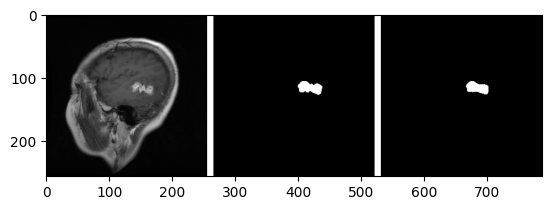

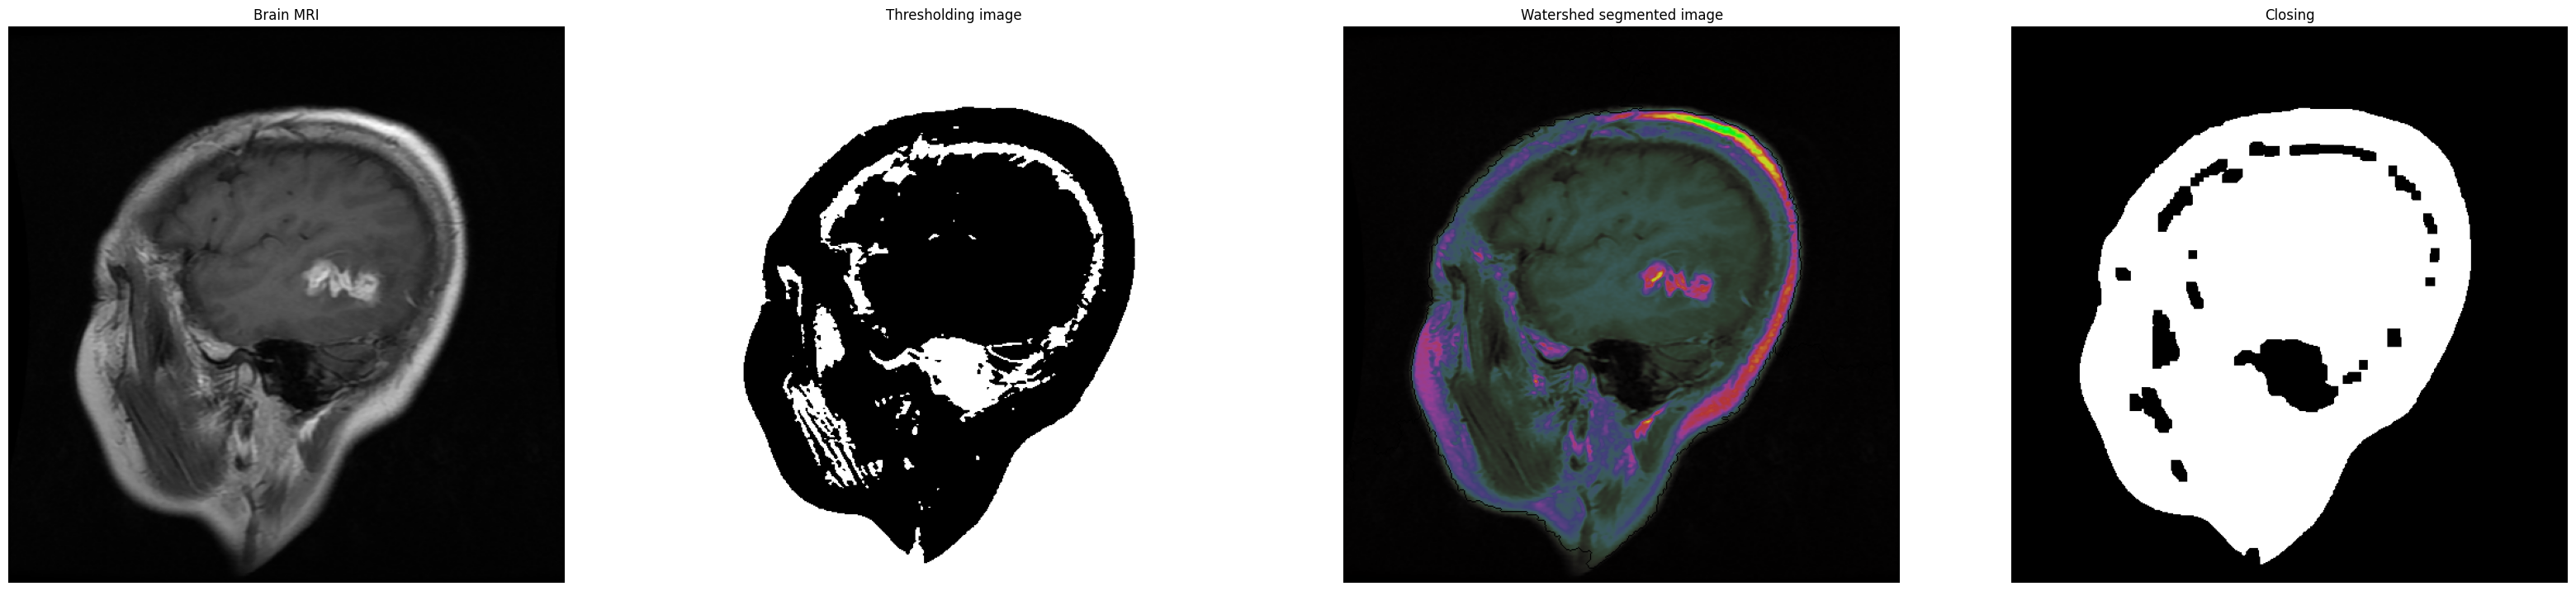

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/DSP Project/results/"
images = os.listdir("/content/drive/MyDrive/DSP Project/results/")[:15]
a  = "33.png"
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a
print(watershed("/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a))

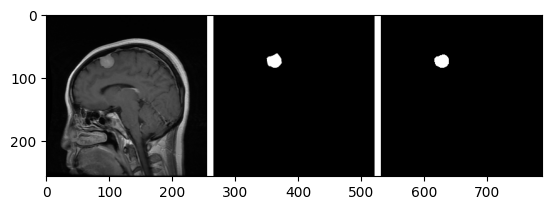

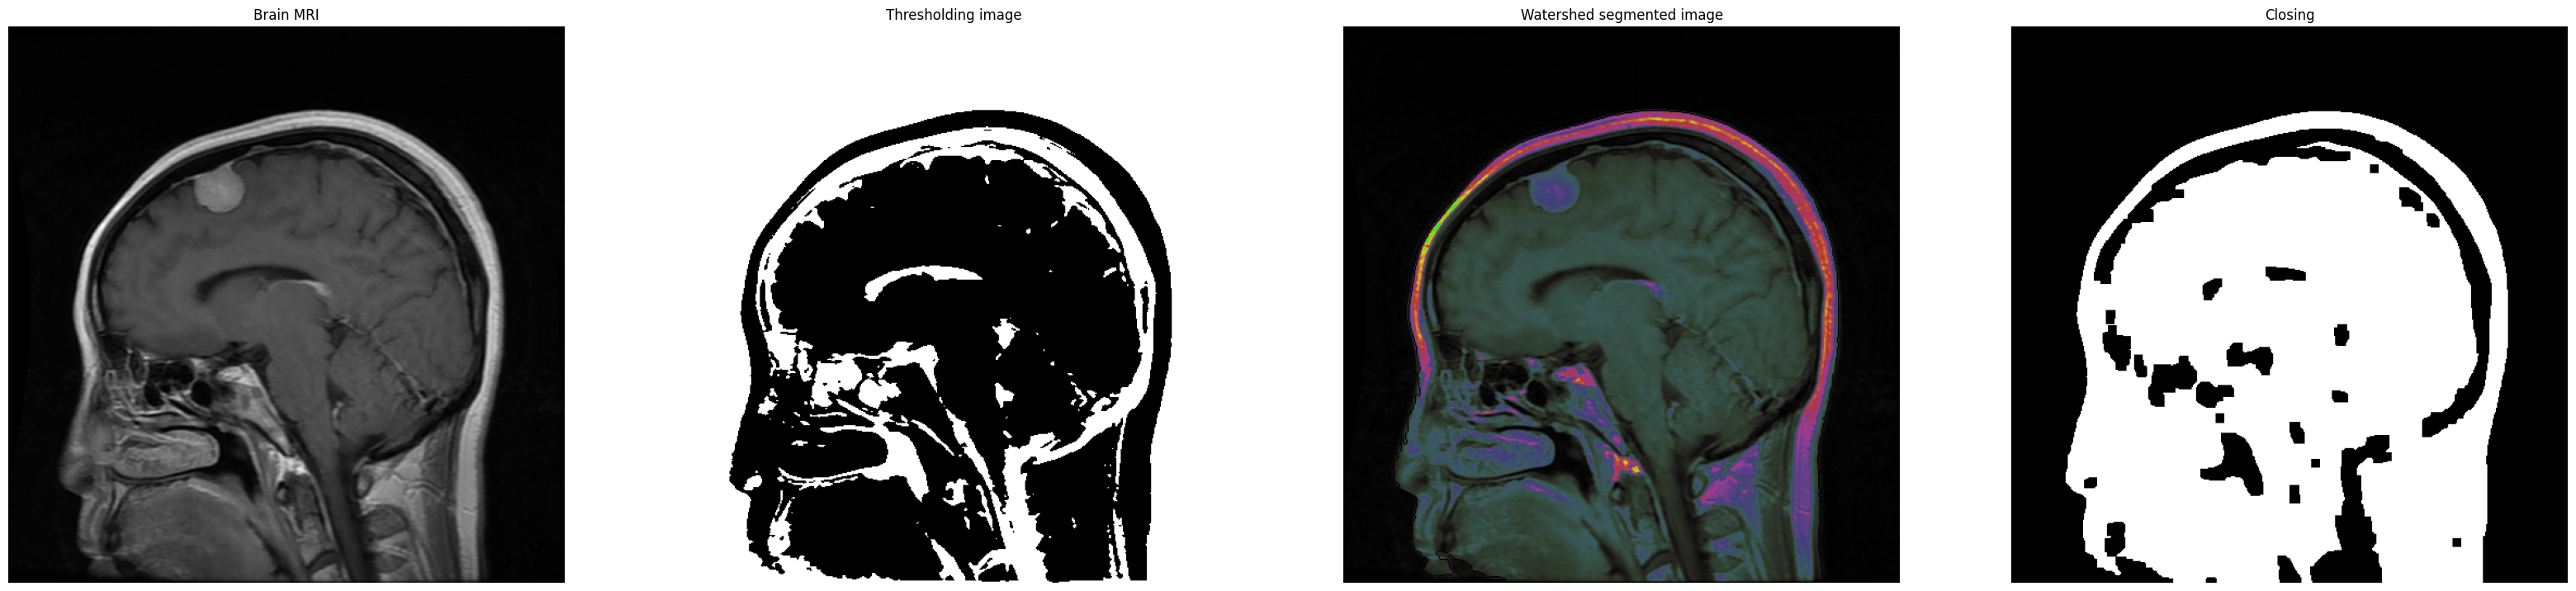

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/DSP Project/results/"
images = os.listdir("/content/drive/MyDrive/DSP Project/results/")[:15]
a  = images[2]
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a
print(watershed("/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a))

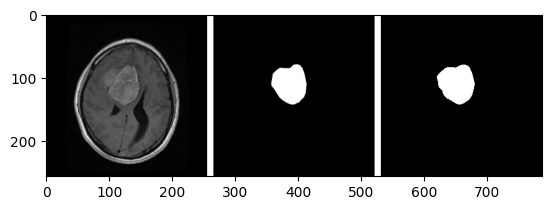

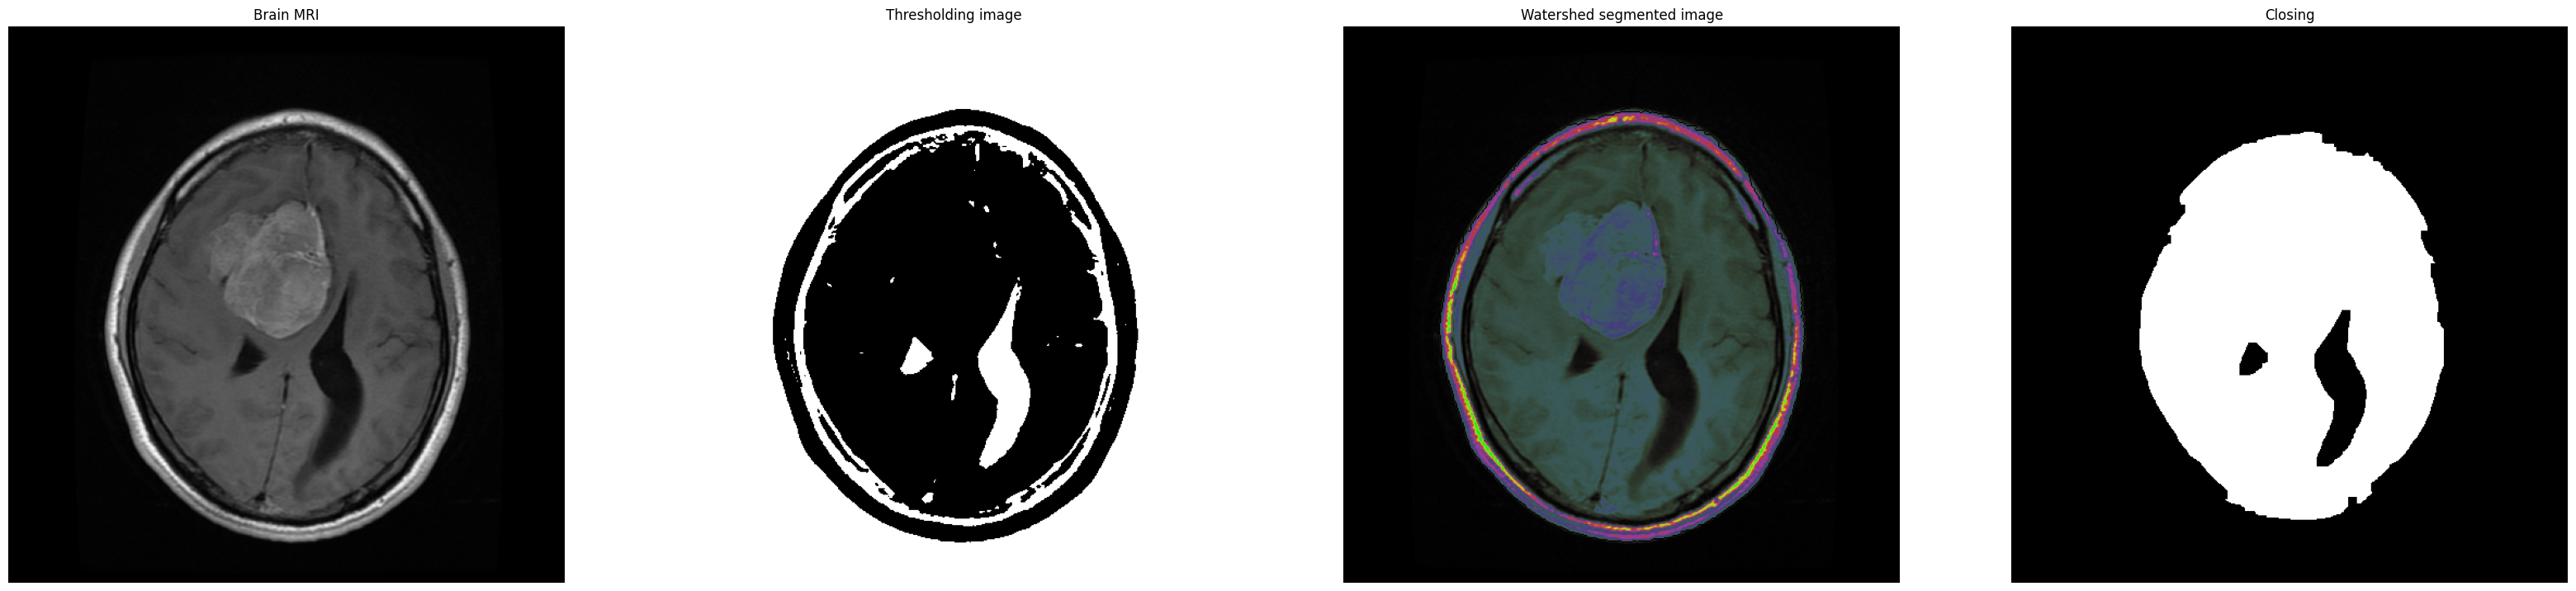

None


In [ ]:
import matplotlib.pyplot as plt


dir = "/content/drive/MyDrive/DSP Project/results/"
images = os.listdir("/content/drive/MyDrive/DSP Project/results/")[:15]
a  = images[10]
img1 = plt.imread(dir+ a)
plt.imshow(img1, cmap='gray')

img_path = "/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a
print(watershed("/content/drive/MyDrive/DSP Project/brain_tumor_dataset/data/images/" +a))